In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import (Input, Add, Dense, Activation,
ZeroPadding2D, BatchNormalization, Flatten, Conv2D,
AveragePooling2D, MaxPooling2D, Dropout)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import (ReduceLROnPlateau,
EarlyStopping, ModelCheckpoint, LearningRateScheduler)
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

In [96]:
sales_df = pd.read_csv('DataSet/sales_data_sample.csv', sep=',', decimal='.', encoding = "ISO-8859-1")
sales_df.head(10)

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium
5,10168,36,96.66,1,3479.76,10/28/2003 0:00,Shipped,4,10,2003,...,9408 Furth Circle,NaN,Burlingame,CA,94217,USA,NaN,Hirano,Juri,Medium
6,10180,29,86.13,9,2497.77,11/11/2003 0:00,Shipped,4,11,2003,...,"184, chausse de Tournai",NaN,Lille,NaN,59000,France,EMEA,Rance,Martine,Small
7,10188,48,100.00,1,5512.32,11/18/2003 0:00,Shipped,4,11,2003,...,"Drammen 121, PR 744 Sentrum",NaN,Bergen,NaN,N 5804,Norway,EMEA,Oeztan,Veysel,Medium
8,10201,22,98.57,2,2168.54,12/1/2003 0:00,Shipped,4,12,2003,...,5557 North Pendale Street,NaN,San Francisco,CA,NaN,USA,NaN,Murphy,Julie,Small
9,10211,41,100.00,14,4708.44,1/15/2004 0:00,Shipped,1,1,2004,...,"25, rue Lauriston",NaN,Paris,NaN,75016,France,EMEA,Perrier,Dominique,Medium


In [103]:
sales_df = pd.read_csv('DataSet/sales_data_sample.csv', sep=',', decimal='.', encoding = "ISO-8859-1")
sales_df = sales_df.drop(['ADDRESSLINE1', 'ADDRESSLINE2', 'POSTALCODE', 'CITY',
'TERRITORY', 'PHONE', 'STATE', 'CONTACTFIRSTNAME',
'CONTACTLASTNAME', 'CUSTOMERNAME', 'ORDERNUMBER', 'STATUS', 'ORDERDATE', 'QTR_ID'], axis=1)



def dummies(x):
    dummy = pd.get_dummies(sales_df[x])
    sales_df.drop(columns = x , inplace = True)
    return pd.concat([sales_df, dummy], axis = 1)

sales_df = dummies("COUNTRY")
sales_df = dummies("PRODUCTLINE")
sales_df = dummies("DEALSIZE")
sales_df['PRODUCTCODE'] = pd.Categorical(sales_df['PRODUCTCODE']).codes
sales_df_simplyfied = sales_df[["QUANTITYORDERED", "PRICEEACH", "ORDERLINENUMBER", "SALES", "MONTH_ID", "YEAR_ID", "MSRP", "PRODUCTCODE"]]

sales_df_simplyfied



,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE
0,30,95.70,2,2871.00,2,2003,95,0
1,34,81.35,5,2765.90,5,2003,95,0
2,41,94.74,2,3884.34,7,2003,95,0
3,45,83.26,6,3746.70,8,2003,95,0
4,49,100.00,14,5205.27,10,2003,95,0
...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,12,2004,54,108
2819,29,100.00,1,3978.51,1,2005,54,108
2820,43,100.00,4,5417.57,3,2005,54,108
2821,34,62.24,1,2116.16,3,2005,54,108


In [104]:
#MINIRETO 7
sales_df_simplyfied.head(10)

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE
0,30,95.70,2,2871.00,2,2003,95,0
1,34,81.35,5,2765.90,5,2003,95,0
2,41,94.74,2,3884.34,7,2003,95,0
3,45,83.26,6,3746.70,8,2003,95,0
4,49,100.00,14,5205.27,10,2003,95,0
5,36,96.66,1,3479.76,10,2003,95,0
6,29,86.13,9,2497.77,11,2003,95,0
7,48,100.00,1,5512.32,11,2003,95,0
8,22,98.57,2,2168.54,12,2003,95,0
9,41,100.00,14,4708.44,1,2004,95,0


In [105]:
#MINIRETO 7
corr_df = sales_df_simplyfied.corr(method='pearson')
corr_df.style.background_gradient(cmap='coolwarm')


,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE
QUANTITYORDERED,1.000000,0.005564,-0.018397,0.551426,-0.039048,0.069535,0.017881,-0.005400
PRICEEACH,0.005564,1.000000,-0.020965,0.657841,0.005152,-0.005938,0.670625,-0.276001
ORDERLINENUMBER,-0.018397,-0.020965,1.000000,-0.058400,0.034016,-0.057367,-0.021067,0.034087
SALES,0.551426,0.657841,-0.058400,1.000000,-0.009605,0.035647,0.635239,-0.335955
MONTH_ID,-0.039048,0.005152,0.034016,-0.009605,1.000000,-0.430163,0.008170,-0.011870
YEAR_ID,0.069535,-0.005938,-0.057367,0.035647,-0.430163,1.000000,-0.014310,0.024560
MSRP,0.017881,0.670625,-0.021067,0.635239,0.008170,-0.014310,1.000000,-0.544184
PRODUCTCODE,-0.005400,-0.276001,0.034087,-0.335955,-0.011870,0.024560,-0.544184,1.000000


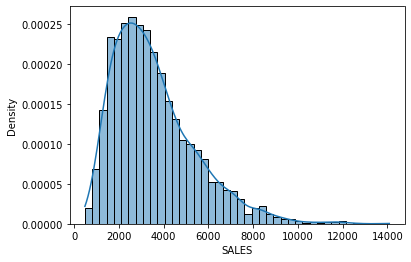

In [106]:
ax = sns.histplot(sales_df["SALES"], kde=True, stat="density", linewidth=1)


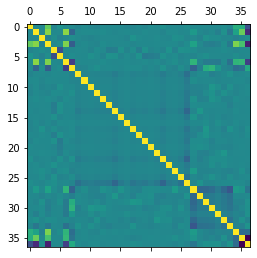

In [107]:
#MINIRETO 7.2
corr_df = sales_df.corr(method='pearson')
plt.matshow(corr_df)

In [119]:
#TAREA 6
scaler = StandardScaler()
sales_df_scaled = scaler.fit_transform(sales_df)
pd.DataFrame(sales_df_scaled).head(10)

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,-0.522891,0.596978,-1.057059,-0.370825,-1.392909,-1.165170,-0.142246,-1.70278,-0.264819,-0.140961,...,-0.721812,2.743848,-0.348674,-0.300637,-0.167454,-0.34547,-0.523371,-0.242672,-0.980703,1.09637
1,-0.112201,-0.114450,-0.347015,-0.427897,-0.572337,-1.165170,-0.142246,-1.70278,-0.264819,-0.140961,...,-0.721812,2.743848,-0.348674,-0.300637,-0.167454,-0.34547,-0.523371,-0.242672,-0.980703,1.09637
2,0.606505,0.549384,-1.057059,0.179443,-0.025289,-1.165170,-0.142246,-1.70278,-0.264819,-0.140961,...,-0.721812,2.743848,-0.348674,-0.300637,-0.167454,-0.34547,-0.523371,-0.242672,1.019676,-0.91210
3,1.017195,-0.019759,-0.110334,0.104701,0.248235,-1.165170,-0.142246,-1.70278,-0.264819,-0.140961,...,-0.721812,2.743848,-0.348674,-0.300637,-0.167454,-0.34547,-0.523371,-0.242672,1.019676,-0.91210
4,1.427884,0.810158,1.783116,0.896740,0.795284,-1.165170,-0.142246,-1.70278,-0.264819,-0.140961,...,-0.721812,2.743848,-0.348674,-0.300637,-0.167454,-0.34547,-0.523371,-0.242672,1.019676,-0.91210
5,0.093143,0.644571,-1.293740,-0.040254,0.795284,-1.165170,-0.142246,-1.70278,-0.264819,-0.140961,...,-0.721812,2.743848,-0.348674,-0.300637,-0.167454,-0.34547,-0.523371,-0.242672,1.019676,-0.91210
6,-0.625563,0.122527,0.599710,-0.573498,1.068808,-1.165170,-0.142246,-1.70278,-0.264819,-0.140961,...,-0.721812,2.743848,-0.348674,-0.300637,-0.167454,-0.34547,-0.523371,-0.242672,-0.980703,1.09637
7,1.325212,0.810158,-1.293740,1.063475,1.068808,-1.165170,-0.142246,-1.70278,-0.264819,-0.140961,...,-0.721812,2.743848,-0.348674,-0.300637,-0.167454,-0.34547,-0.523371,-0.242672,1.019676,-0.91210
8,-1.344270,0.739263,-1.057059,-0.752278,1.342332,-1.165170,-0.142246,-1.70278,-0.264819,-0.140961,...,-0.721812,2.743848,-0.348674,-0.300637,-0.167454,-0.34547,-0.523371,-0.242672,-0.980703,1.09637
9,0.606505,0.810158,1.783116,0.626949,-1.666433,0.264328,-0.142246,-1.70278,-0.264819,-0.140961,...,-0.721812,2.743848,-0.348674,-0.300637,-0.167454,-0.34547,-0.523371,-0.242672,1.019676,-0.91210


In [109]:
sales_df_scaled.shape

(2823, 37)

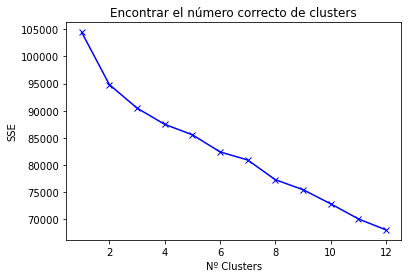

In [110]:
scores = []
range_values = range(1, 13)
for i in range_values:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(sales_df_scaled)
    scores.append(kmeans.inertia_) 
plt.plot(range_values, scores, 'bx-')
plt.title('Encontrar el número correcto de clusters')
plt.xlabel('Nº Clusters')
plt.ylabel('SSE')
plt.savefig('C:\\Users\\saba-\\anaconda3\\Lib\\site-packages\\KnowledgeRevolution\\IAMarketing\\IAApp\\static\\graphics\\SSErrorGraphic.png')

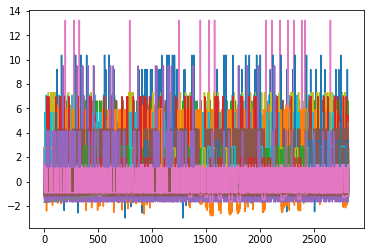

In [111]:
plt.plot(sales_df_scaled)

In [112]:
kmeans = KMeans(5)
kmeans.fit(sales_df_scaled)
labels = kmeans.labels_
serie = pd.Series(labels)
serie.to_frame().to_html()
labels

array([1, 1, 3, ..., 2, 1, 2])

In [113]:
kmeans.cluster_centers_.shape

(5, 37)

In [114]:
kmeans.cluster_centers_

array([[ 1.91866905e-01, -5.74560399e-02, -1.01994969e-02,
         3.37220925e-02, -2.77772363e-01, -9.45247300e-01,
        -6.85405180e-02,  7.41645271e-02, -2.64818590e-01,
        -1.40960782e-01, -1.08756411e-01, -1.59457854e-01,
        -1.51083047e-01, -1.83540987e-01, -3.53764699e-01,
        -1.49852034e-01, -7.54985803e-02, -2.04199454e-01,
        -1.36988279e-01, -1.76194660e-01,  1.03719296e+01,
        -1.69676420e-01, -3.71278389e-01, -1.43552692e-01,
        -1.05371495e-01, -2.31843481e-01, -7.42934467e-01,
         3.31794775e-01,  4.72398175e-01,  2.69919671e-01,
        -3.00636636e-01, -1.67453834e-01, -3.45470292e-01,
        -4.29753001e-01, -7.48466701e-02,  9.64241987e-02,
        -6.23628056e-02],
       [-4.65312182e-01, -7.42199223e-01,  4.09527750e-02,
        -8.16535796e-01,  1.03789153e-02, -3.27402160e-03,
        -6.15765616e-01,  3.09449046e-01,  2.93653756e-02,
        -1.94105560e-02,  2.52156683e-02,  2.06019547e-02,
        -1.02678916e-02, -3.31

In [115]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_centers[["QUANTITYORDERED", "PRICEEACH", "ORDERLINENUMBER", "SALES", "MONTH_ID", "YEAR_ID", "MSRP", "PRODUCTCODE"]].to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr>\n      <th></th>\n      <th>QUANTITYORDERED</th>\n      <th>PRICEEACH</th>\n      <th>ORDERLINENUMBER</th>\n      <th>SALES</th>\n      <th>MONTH_ID</th>\n      <th>YEAR_ID</th>\n      <th>MSRP</th>\n      <th>PRODUCTCODE</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>0.191867</td>\n      <td>-0.057456</td>\n      <td>-0.010199</td>\n      <td>0.033722</td>\n      <td>-0.277772</td>\n      <td>-0.945247</td>\n      <td>-0.068541</td>\n      <td>0.074165</td>\n    </tr>\n    <tr>\n      <th>1</th>\n      <td>-0.465312</td>\n      <td>-0.742199</td>\n      <td>0.040953</td>\n      <td>-0.816536</td>\n      <td>0.010379</td>\n      <td>-0.003274</td>\n      <td>-0.615766</td>\n      <td>0.309449</td>\n    </tr>\n    <tr>\n      <th>2</th>\n      <td>0.548114</td>\n      <td>0.432324</td>\n      <td>0.011813</td>\n      <td>0.318051</td>\n      <td>-0.136858</td>\n      <td>0.197451</td>\n      <td>-0

In [116]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns =
[sales_df.columns])
cluster_centers[["QUANTITYORDERED", "PRICEEACH", "ORDERLINENUMBER", "SALES", "MONTH_ID", "YEAR_ID", "MSRP", "PRODUCTCODE"]].to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr>\n      <th></th>\n      <th>QUANTITYORDERED</th>\n      <th>PRICEEACH</th>\n      <th>ORDERLINENUMBER</th>\n      <th>SALES</th>\n      <th>MONTH_ID</th>\n      <th>YEAR_ID</th>\n      <th>MSRP</th>\n      <th>PRODUCTCODE</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>36.961538</td>\n      <td>82.499615</td>\n      <td>6.423077</td>\n      <td>3615.989615</td>\n      <td>6.076923</td>\n      <td>2003.153846</td>\n      <td>97.961538</td>\n      <td>56.115385</td>\n    </tr>\n    <tr>\n      <th>1</th>\n      <td>30.560800</td>\n      <td>68.687864</td>\n      <td>6.639200</td>\n      <td>2050.206680</td>\n      <td>7.130400</td>\n      <td>2003.812800</td>\n      <td>75.973600</td>\n      <td>63.545600</td>\n    </tr>\n    <tr>\n      <th>2</th>\n      <td>40.431287</td>\n      <td>92.378816</td>\n      <td>6.516082</td>\n      <td>4139.593231</td>\n      <td>6.592105</td>\n      <td>2003.953216</

In [ ]:
labels.shape # Etiquetas del clúster asociado a cada observación
labels.max()
labels.min()
y_kmeans = kmeans.fit_predict(sales_df_scaled)
y_kmeans
y_kmeans.shape

In [ ]:
sale_df_cluster = pd.concat([sales_df, pd.DataFrame({'CLUSTER':labels})], axis = 1)
sale_df_cluster_aux = sale_df_cluster[["QUANTITYORDERED", "PRICEEACH", "ORDERLINENUMBER", "SALES", "MONTH_ID", "YEAR_ID", "MSRP", "PRODUCTCODE", "CLUSTER"]]
sale_df_cluster_aux.head(15).to_html()

In [ ]:
x = 0
for i in sales_df.columns[:8]:
    plt.figure(figsize = (15, 3))
    for j in range(5):
        plt.subplot(1, 5, j+1)
        cluster = sale_df_cluster[sale_df_cluster['CLUSTER'] == j]
        cluster[i].hist()
        plt.title('{} {} '.format(i,j))    
    plt.savefig(f'C:\\Users\\saba-\\anaconda3\\Lib\\site-packages\\KnowledgeRevolution\\IAMarketing\\IAApp\\static\\graphics\\ClustersColumn{x}.png')
    x += 1
    plt.show()
    

In [ ]:
pca = PCA(n_components = 3)
principal_comp = pca.fit_transform(sales_df_scaled)
principal_comp[0]

In [ ]:
pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1', 'pca2', 'pca3'])
pca_df.head(15).to_html()

In [ ]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df

In [ ]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()
suma = 0
for i in pca.explained_variance_ratio_:
    suma += i
    print(i)
    
print(suma)

In [ ]:
# Visualizar los clústeres con 3D-Scatterplot
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3',
color = 'cluster', symbol = 'cluster', size_max = 18, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))
fig.write_html("C:\\Users\\saba-\\OneDrive\\Imatges\\figuraa.html")

In [ ]:
pca = PCA(n_components = 2)
principal_comp = pca.fit_transform(sales_df_scaled)
pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1', 'pca2'])
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
ax = sns.scatterplot(x = "pca1", y = "pca2", hue = "cluster", data = pca_df, palette = ["red", "green", "blue",
"pink", "yellow"])
plt.show()

In [ ]:
scaler = StandardScaler()
cluster_df_scaled = scaler.fit_transform(cluster_centers)
columns = ['QUANTITY', 'PRICE', 'LINENUMBER',
       'SALES','MONTH','YEAR', 'MSRP']
plt.figure(figsize = (20, 10))
for cluster in range(4):
    plt.subplot(2, 2, cluster+1)
    plt.bar(columns, cluster_df_scaled[cluster][:7])
    plt.title(f'CLUSTER {cluster}')
plt.show()
plt.savefig('C:\\Users\\saba-\\anaconda3\\Lib\\site-packages\\KnowledgeRevolution\\IAMarketing\\IAApp\\static\\graphics\\ClustersDiff.png')